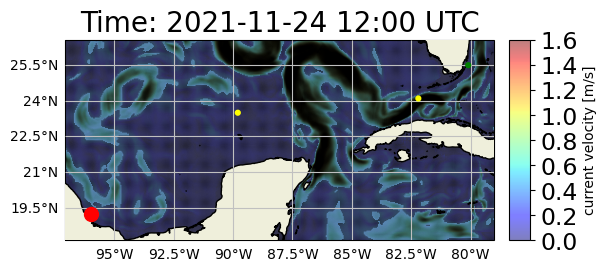

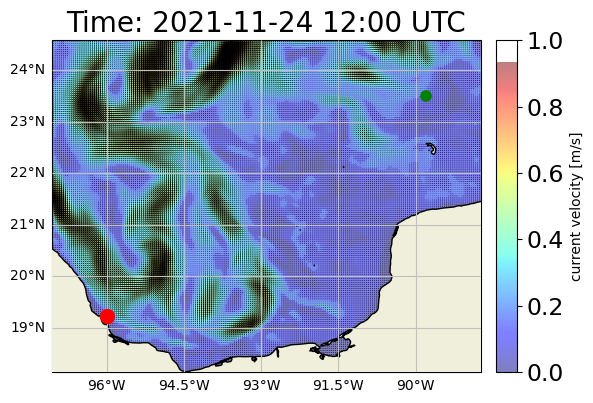

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|##############################################|  1.0000/1.0 [12:54<00:00, 774.91s/sim_s]


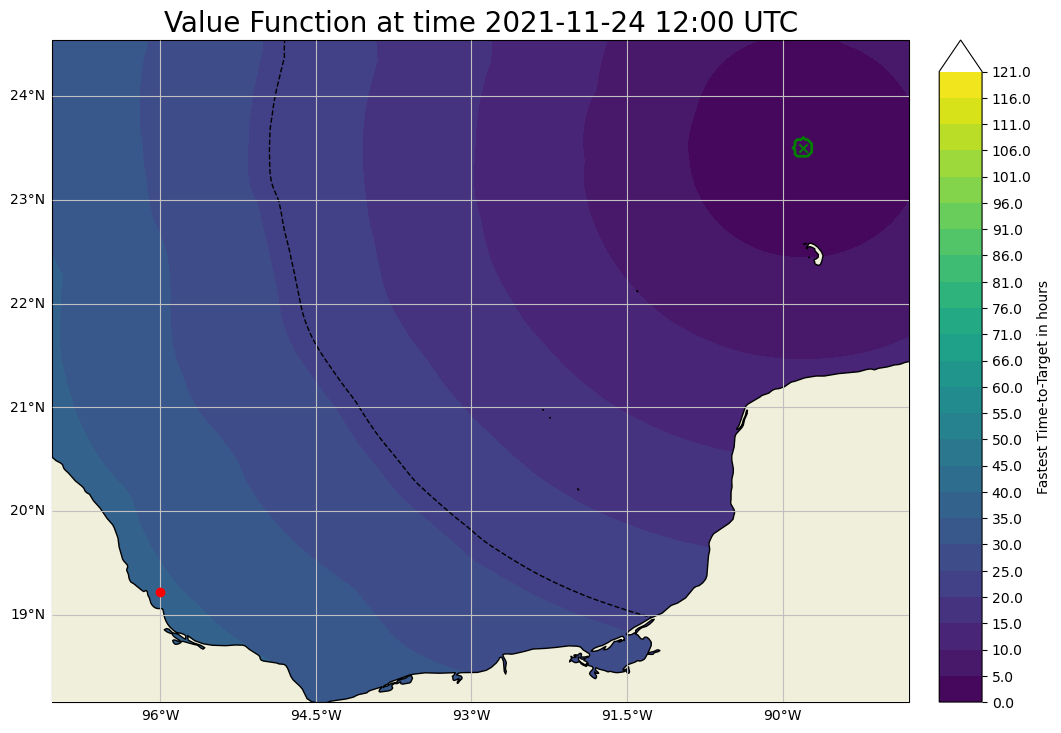

 30%|████████████████                                      | 214/720 [00:05<00:12, 41.20it/s]


Waypoint 0 reached:
1 day, 11:40:00


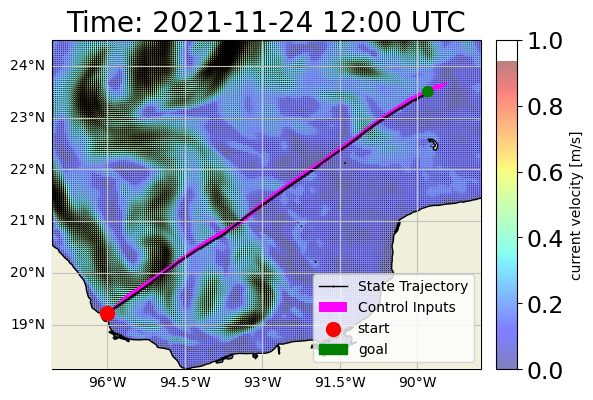

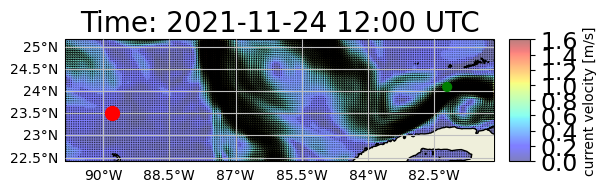

100%|##############################################|  1.0000/1.0 [08:16<00:00, 496.40s/sim_s]


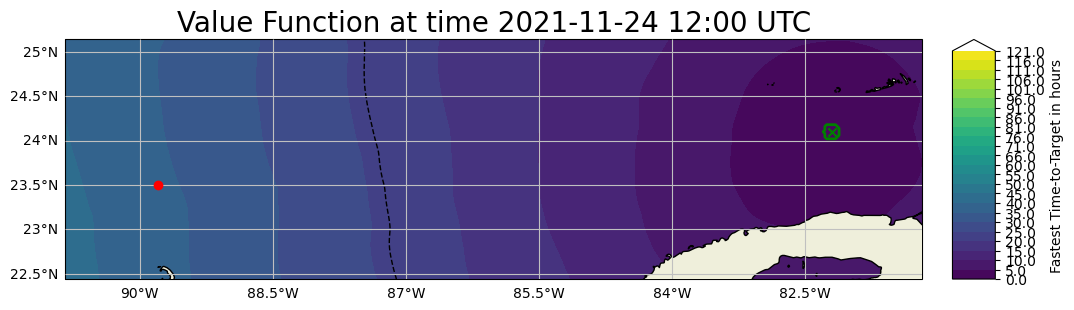

 30%|████████████████▏                                     | 216/720 [00:04<00:10, 48.72it/s]


Waypoint 1 reached:
1 day, 12:00:00


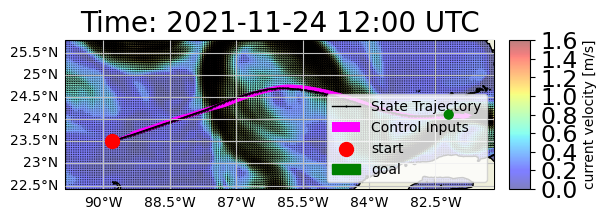

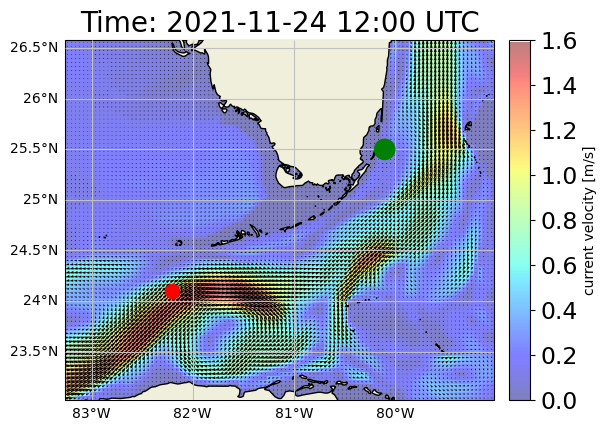

100%|##############################################|  1.0000/1.0 [04:02<00:00, 242.43s/sim_s]


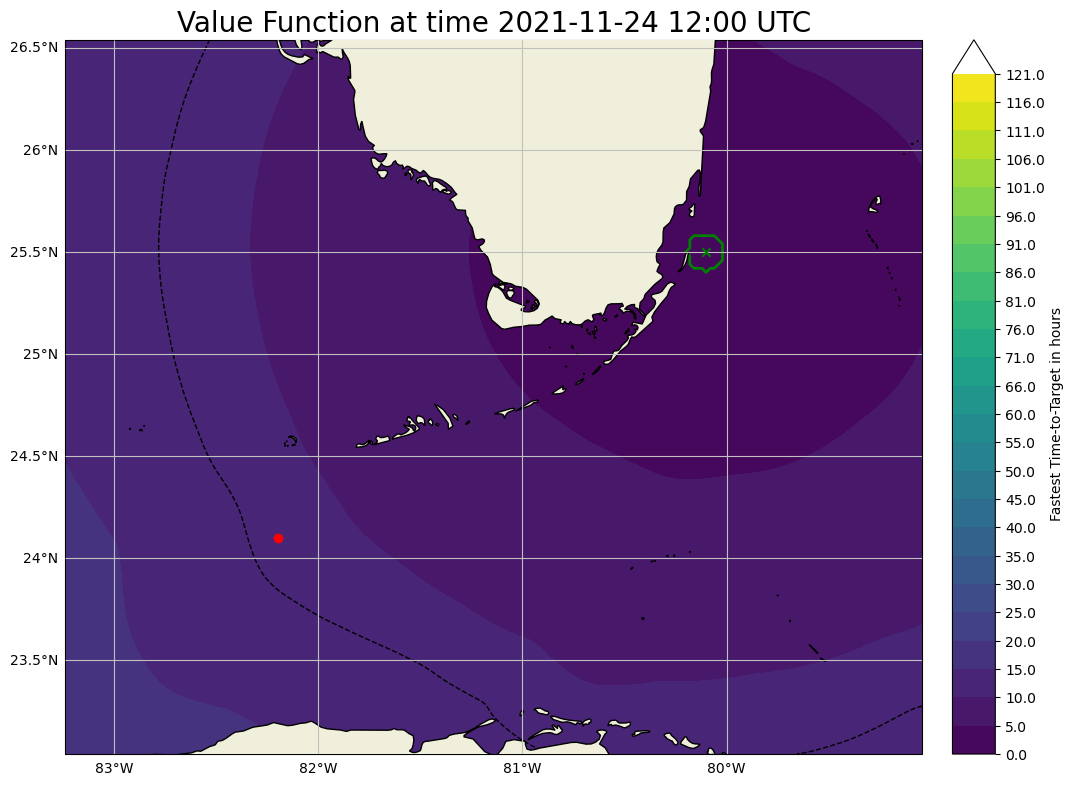

  9%|█████▏                                                 | 68/720 [00:00<00:07, 82.02it/s]


Waypoint 2 reached:
11:20:00


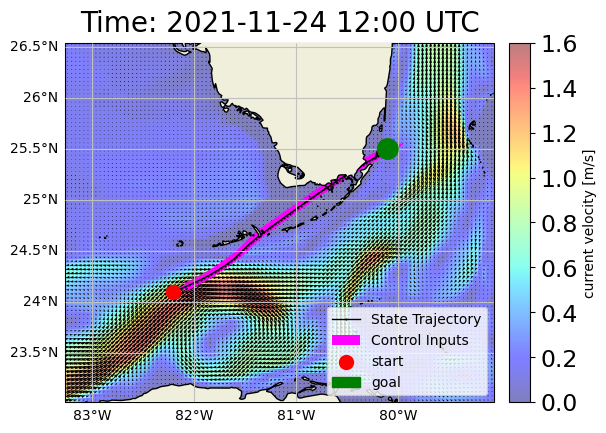

In [1]:
import datetime
import logging

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner import (
    HJReach2DPlanner,
)
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
from ocean_navigation_simulator.environment.NavigationWaypointsProblem import (
    NavigationWaypointsProblem,
)
from ocean_navigation_simulator.environment.Platform import PlatformState
from ocean_navigation_simulator.environment.PlatformState import SpatialPoint
from ocean_navigation_simulator.utils import units
from ocean_navigation_simulator.utils.misc import set_arena_loggers

set_arena_loggers(logging.DEBUG)

#in form lon,lat
# list_of_waypoints = [(-95.85,19.4),(-89.8,24.5),(-80.3,24.6),(-79.9,25.46)] # Miami to Veracruz
# list_of_waypoints = [(-82.5,23.7),(-82.0,24.1),(-80.3,24.6)] # Default with waypoint
# list_of_waypoints = [(-82.5,23.7),(-80.3,24.6)] #Default
# list_of_waypoints = [(-89.8,30.1),(-83.0,24.73),(-80.3,24.6),(-79.76,25.5)]
list_of_waypoints = [(-96.0,19.22),(-89.8, 23.5),(-82.2,24.1),(-80.1,25.5)]

total_time = 0
axes = None

# Initialize the Arena (holds all data sources and the platform, everything except controller)
arena_overall = ArenaFactory.create(
    scenario_name="gulf_of_mexico_HYCOM_hindcast_BN",
    # Note: uncomment this to download the hindcast data if not already locally available
    # t_interval=[
    #     datetime.datetime(2021, 11, 23, 12, 0, tzinfo=datetime.timezone.utc),
    #     datetime.datetime(2021, 11, 30, 12, 0, tzinfo=datetime.timezone.utc)]
)

# we can also download the respective files directly to a temp folder, then t_interval needs to be set
# % Specify Navigation Problem
x_0_overall = PlatformState(
    lon=units.Distance(deg=list_of_waypoints[0][0]),
    lat=units.Distance(deg=list_of_waypoints[0][1]),
    # date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc) + datetime.timedelta(seconds=total_time*600),
    date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc) ,
)
x_T_overall = SpatialPoint(lon=units.Distance(deg=list_of_waypoints[-1][0]), lat=units.Distance(deg=list_of_waypoints[-1][1]))

problem_overall = NavigationWaypointsProblem(
    start_state=x_0_overall,
    end_region=x_T_overall,
    target_radius=0.1,
)

problem_overall.add_waypoints(list_of_waypoints[1:-1])

# %% Plot the problem on the map
t_interval, lat_bnds, lon_bnds = arena_overall.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=x_0_overall.to_spatio_temporal_point(), x_T=x_T_overall, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax_overall = arena_overall.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=x_0_overall.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
problem_overall.plot(ax=ax_overall)
plt.show()

state_trajectory_overall = []

x = 0
for first, second in zip(list_of_waypoints, list_of_waypoints[1:]):

    # Initialize the Arena (holds all data sources and the platform, everything except controller)
    arena = ArenaFactory.create(
        scenario_name="gulf_of_mexico_HYCOM_hindcast_BN",
        # Note: uncomment this to download the hindcast data if not already locally available
        # t_interval=[
        #     datetime.datetime(2021, 11, 23, 12, 0, tzinfo=datetime.timezone.utc),
        #     datetime.datetime(2021, 11, 30, 12, 0, tzinfo=datetime.timezone.utc)]
    )
    # we can also download the respective files directly to a temp folder, then t_interval needs to be set
    # % Specify Navigation Problem
    x_0 = PlatformState(
        lon=units.Distance(deg=first[0]),
        lat=units.Distance(deg=first[1]),
        date_time=datetime.datetime(2021, 11, 24, 12, 0, tzinfo=datetime.timezone.utc),
    )
    x_T = SpatialPoint(lon=units.Distance(deg=second[0]), lat=units.Distance(deg=second[1]))

    problem = NavigationProblem(
        start_state=x_0,
        end_region=x_T,
        target_radius=0.1,
    )

    # %% Plot the problem on the map
    t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
        x_0=x_0.to_spatio_temporal_point(), x_T=x_T, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
    )

    ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
        time=x_0.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
    )
    problem.plot(ax=ax)
    plt.show()
    # %% Instantiate and runm the HJ Planner
    specific_settings = {
        "replan_on_new_fmrc": True,
        "replan_every_X_seconds": False,
        "direction": "multi-time-reach-back",
        "n_time_vector": 200,
        "closed_loop": True,  # to run closed-loop or open-loop
        # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "deg_around_xt_xT_box": 1.0,  # area over which to run HJ_reachability
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "T_goal_in_seconds": 3600 * 24 * 5,
        "use_geographic_coordinate_system": True,
        "progress_bar": True,
        "initial_set_radii": [
            0.1,
            0.1,
        ],  # this is in deg lat, lon. Note: for Backwards-Reachability this should be bigger.
        # Note: grid_res should always be bigger than initial_set_radii, otherwise reachability behaves weirdly.
        "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "d_max": 0.0,
        # 'EVM_threshold': 0.3 # in m/s error when floating in forecasted vs sensed currents
        # 'fwd_back_buffer_in_seconds': 0.5,  # this is the time added to the earliest_to_reach as buffer for forward-backward
        "platform_dict": arena.platform.platform_dict,
    }
    planner = HJReach2DPlanner(problem=problem, specific_settings=specific_settings)

    # % Run reachability planner
    observation = arena.reset(platform_state=x_0)
    action = planner.get_action(observation=observation)
    # %% Various plotting of the reachability computations
    planner.plot_reachability_snapshot(
        rel_time_in_seconds=0,
        granularity_in_h=5,
        alpha_color=1,
        time_to_reach=True,
        fig_size_inches=(12, 12),
        plot_in_h=True,
    )
    # planner.plot_reachability_snapshot_over_currents(rel_time_in_seconds=0, granularity_in_h=5, time_to_reach=False)
    # planner.plot_reachability_animation(time_to_reach=False, granularity_in_h=5, filename="test_reach_animation.mp4")
    # planner.plot_reachability_animation(time_to_reach=True, granularity_in_h=5, with_opt_ctrl=True,
    #                                     filename="test_reach_animation_w_ctrl.mp4", forward_time=True)
    #%% save planner state and reload it
    # Save it to a folder
    # planner.save_planner_state("saved_planner/")
    # Load it from the folder
    # loaded_planner = HJReach2DPlanner.from_saved_planner_state(folder="saved_planner/", problem=problem)
    # loaded_planner.last_data_source = arena.ocean_field.hindcast_data_source
    # observation = arena.reset(platform_state=x_0)
    # loaded_planner._update_current_data(observation=observation)
    # planner = loaded_planner
    # %% Let the controller run closed-loop within the arena (the simulation loop)
    # Note this runs the sim for a fixed time horizon (does not terminate when reaching the goal)
    #BN: I added this in; it's a flag saying whether the platform has arrived in the target area yet
    unsolved = 1

    for i in tqdm(range(int(3600 * 24 * 5 / 600))):  # 5 days
        action = planner.get_action(observation=observation)
        observation = arena.step(action)

        if (problem.is_done(observation.platform_state) ) and (unsolved):
            print("Waypoint " + str(x) + " reached:")
            print(datetime.timedelta(seconds=i*600))
            unsolved = 0
            total_time += i
            break
    arena.plot_all_on_map(problem=problem)
    # if state_trajectory_overall is not None:
    #     state_trajectory_overall = np.concatenate(state_trajectory_overall, arena.get_state_trajectory())
    # else:
    #     state_trajectory_overall = arena.return_state_trajectory()
    state_trajectory_overall.append(arena.return_state_trajectory())
    # if axes is not None:
    #     axes = arena.plot_all_on_map(ax = axes, problem=problem, return_ax = True)
    # else:
    #     axes = arena.plot_all_on_map(problem=problem, return_ax = True)
    x += 1

Final destination reached:
498
3 days, 11:00:00


<GeoAxes: title={'center': 'Time: 2021-11-24 12:00 UTC'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

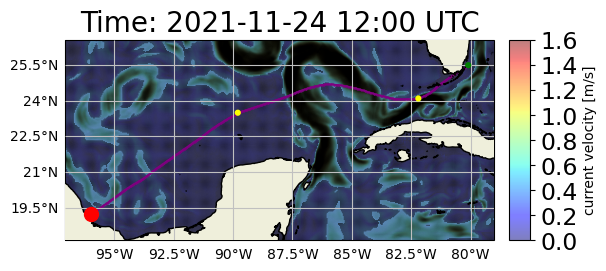

In [2]:
print("Final destination reached:")
print(total_time)
print(datetime.timedelta(seconds=total_time*600))

# %% Plot the problem on the map
t_interval, lat_bnds, lon_bnds = arena_overall.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=x_0_overall.to_spatio_temporal_point(), x_T=x_T_overall, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax_overall = arena_overall.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=x_0_overall.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)

state_trajectory_overall = np.concatenate(state_trajectory_overall)

stride = 1

ax_overall.plot(
    state_trajectory_overall[::stride, 0],
    state_trajectory_overall[::stride, 1],
    "-",
    marker=".",
    markersize=1,
    color="purple",
    linewidth=1,
    label="State Trajectory",
)
problem_overall.plot(ax=ax_overall)


In [6]:
state_trajectory_overall[1][0]

array([-8.2000000e+01,  2.4100000e+01,  1.6377552e+09,  1.0000000e+02,
        1.0000000e+02,  0.0000000e+00])

In [8]:
new = np.concatenate(state_trajectory_overall)

In [10]:
state_trajectory_overall_1 = new

In [11]:
print("Final destination reached:")
print(total_time)
print(datetime.timedelta(seconds=total_time*600))

Final destination reached:
64
10:40:00


<GeoAxes: title={'center': 'Time: 2021-11-24 12:00 UTC'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

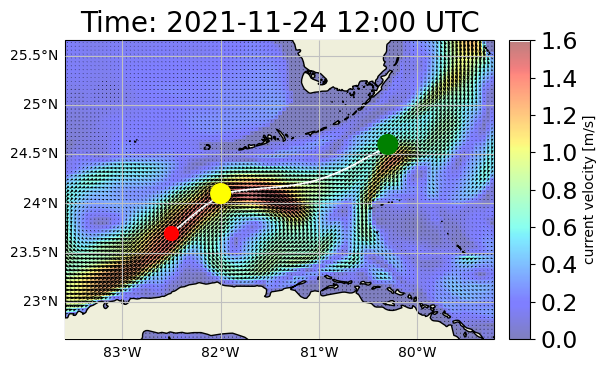

In [20]:
t_interval, lat_bnds, lon_bnds = arena_overall.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=x_0_overall.to_spatio_temporal_point(), x_T=x_T_overall, deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax_overall = arena_overall.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=x_0_overall.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
stride = 1
ax_overall.plot(
    state_trajectory_overall_1[::stride, 0],
    state_trajectory_overall_1[::stride, 1],
    "-",
    marker=".",
    markersize=1,
    color="white",
    linewidth=1,
    label="State Trajectory",
)
index = 0
ax_overall.scatter(
    state_trajectory_overall_1[index, 0],
    state_trajectory_overall_1[index, 1],
    c="orange",
    marker=".",
    s=100,
    label="position at time_index {} of background ".format(index),
)
problem_overall.plot(ax=ax_overall)



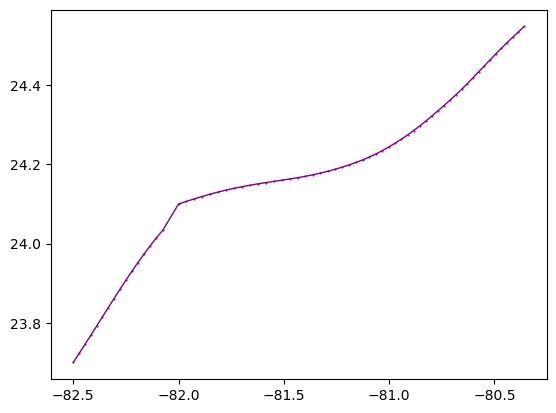

In [15]:
fig, ax = plt.subplots()
ax.plot(
    state_trajectory_overall_1[::stride, 0],
    state_trajectory_overall_1[::stride, 1],
    "-",
    marker=".",
    markersize=1,
    color="purple",
    linewidth=1,
    label="State Trajectory",
)

In [14]:
plt.show()
